# MA23M002 - ABHINAV T K
# CS6910 - Assignment 2

**Github repo:** https://github.com/abhinavtk1/CS6910-A2 <br>
**Wandb report:**

In [ ]:
!pip install wandb

In [3]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
import matplotlib.image as mpimg
import wandb
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import random_split

In [5]:
import os
shared_folder_path = '/content/drive/Shared drives/CS6910-A2'

In [ ]:
classes = ['Amphibia','Animalia','Arachnida','Aves','Fungi',
           'Insecta','Mammalia','Mollusca','Plantae','Reptilia']
IMG_SIZE = (256,256)

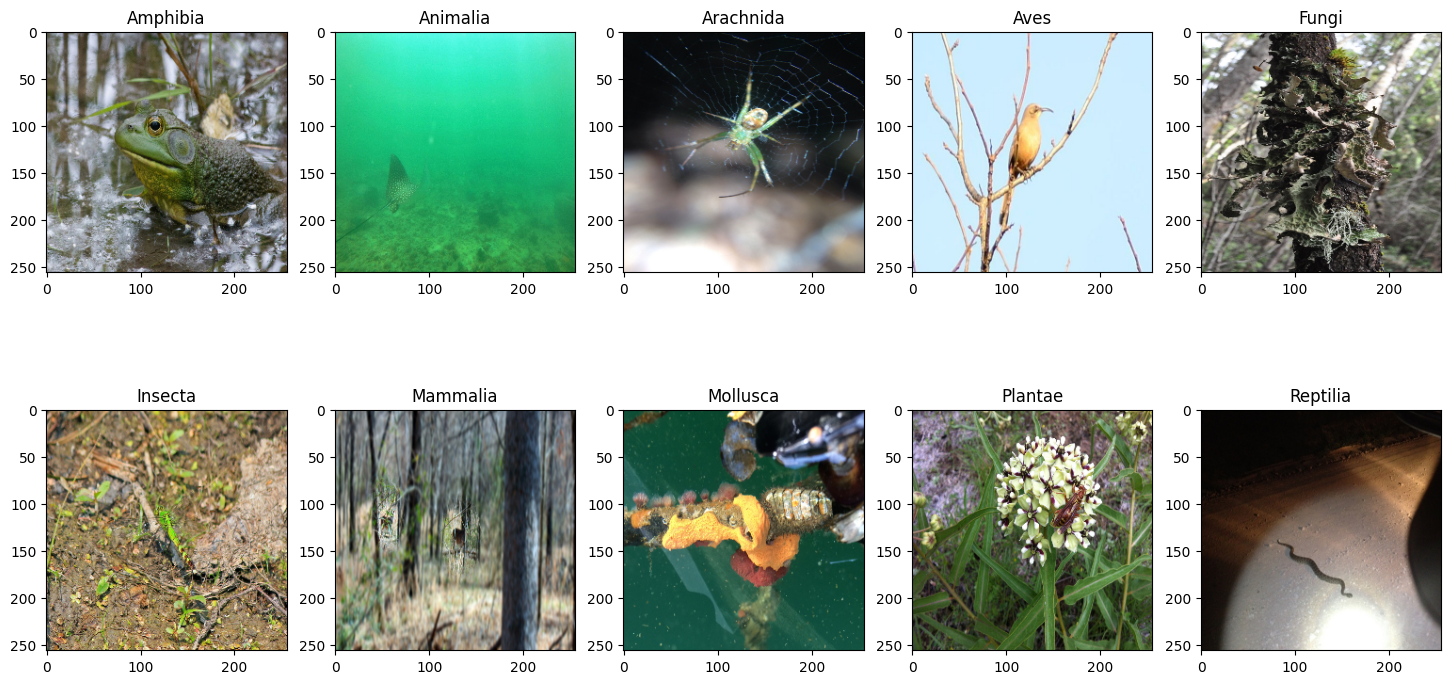

In [ ]:
# visualization of each classes
fig = plt.figure(figsize=(18,9))
r, c = 2, 5
l = 1

for item in classes:
  loc = os.path.join(test, item)
  for img in os.listdir(loc):
    img_loc=(os.path.join(loc,img))
    img = mpimg.imread(img_loc)
    img = cv2.resize(img,IMG_SIZE)
    fig.add_subplot(r, c, l)
    plt.imshow(img)
    plt.title(item)
    l+=1
    break

# Part A: Training from scratch


Question 1

Define model

In [17]:
# Data preparation

# Connect to google drive
from google.colab import drive
drive.mount('/content/drive')
from torchvision import transforms, datasets
#train_dir = '/kaggle/input/inaturalist/inaturalist_12K/train'
#test_dir = '/kaggle/input/inaturalist/inaturalist_12K/val'

train_dir = '/content/drive/MyDrive/CS6910-A2/CS6910-A2/train'
test_dir = '/content/drive/MyDrive/CS6910-A2/CS6910-A2/val'
IMG_SIZE = (224,224)

# Transformations to apply to the images
transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),  # Resize the images
    transforms.ToTensor(),        # Convert images to PyTorch tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) ])  # Normalize the images


# Use ImageFolder to create a dataset
trainset = datasets.ImageFolder(root=train_dir, transform=transform)
val_size = int(0.2 * len(trainset))
train_size = len(trainset) - val_size
trainset, valset = random_split(trainset, [train_size, val_size])
testset = datasets.ImageFolder(root=test_dir, transform=transform)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
# Reference: https://machinelearningmastery.com/building-a-convolutional-neural-network-in-pytorch/

class CNN(nn.Module):
    def __init__(self, trainset, valset, batch_size, num_filters,filter_org, kernel_size,
                 act_fn, num_neurons, batch_norm, dropout_rate):
        super().__init__()

        # DataLoader for the dataset
        self.dataloader_train = torch.utils.data.DataLoader(trainset, batch_size = batch_size, shuffle=True)
        self.dataloader_val = torch.utils.data.DataLoader(valset, batch_size = batch_size, shuffle=True)
        #dataloader_test = torch.utils.data.DataLoader(testset, batch_size = batch_size, shuffle=True)
        self.batch_norm = batch_norm
        #num_layers = 5
        filters = []
        if filter_org=='same':
            filters = [num_filters]*5
        elif filter_org=='double':
            filters = [num_filters, num_filters*2, num_filters*4, num_filters*8, num_filters*16]
        elif filter_org=='half':
            filters = [num_filters, num_filters//2, num_filters//4, num_filters//8, num_filters//16]
        #Conv layer 1
        self.conv1 = nn.Conv2d(3, filters[0],
                               kernel_size=(kernel_size[0],kernel_size[0]),
                               stride=1, padding='same')
        #x = (256 - kernel_size[0] + 2)/1 + 1
        x = 224           # img size
        self.bn1 = nn.BatchNorm2d(filters[0])  # Batch Normalization

        if act_fn=='relu':          #nn.ReLU nn.GELU nn.SiLU nn.Mish nn.Tanh
          self.act1 = nn.ReLU()
        elif act_fn=='tanh':
          self.act1 = nn.Tanh()
        elif act_fn=='gelu':
          self.act1 = nn.GELU()
        elif act_fn=='silu':
          self.act1 = nn.SiLU()
        elif act_fn=='mish':
          self.act1 = nn.Mish()
        self.dropout1 = nn.Dropout(p=dropout_rate)
        self.pool1 = nn.MaxPool2d(2,2)
        x = x//2

        #Conv layer 2
        self.conv2 = nn.Conv2d(filters[0], filters[1],
                               kernel_size=(kernel_size[1],kernel_size[1]),
                               stride=1, padding='same')
        self.bn2 = nn.BatchNorm2d(filters[1])

        if act_fn=='relu':
          self.act2 = nn.ReLU()
        elif act_fn=='tanh':
          self.act2 = nn.Tanh()
        elif act_fn=='gelu':
          self.act2 = nn.GELU()
        elif act_fn=='silu':
          self.act2 = nn.SiLU()
        elif act_fn=='mish':
          self.act2 = nn.Mish()
        self.dropout2 = nn.Dropout(p=dropout_rate)
        self.pool2 = nn.MaxPool2d(2,2)
        x = x//2

        #Conv layer 3
        self.conv3 = nn.Conv2d(filters[1], filters[2],
                               kernel_size=(kernel_size[2],kernel_size[2]),
                               stride=1, padding='same')

        self.bn3 = nn.BatchNorm2d(filters[2])
        if act_fn=='relu':
          self.act3 = nn.ReLU()
        elif act_fn=='tanh':
          self.act3 = nn.Tanh()
        elif act_fn=='gelu':
          self.act3 = nn.GELU()
        elif act_fn=='silu':
          self.act3 = nn.SiLU()
        elif act_fn=='mish':
          self.act3 = nn.Mish()
        self.dropout3 = nn.Dropout(p=dropout_rate)
        self.pool3 = nn.MaxPool2d(2,2)
        x = x//2

        #Conv layer 4
        self.conv4 = nn.Conv2d(filters[2], filters[3],
                               kernel_size=(kernel_size[3],kernel_size[3]),
                               stride=1, padding='same')
        self.bn4 = nn.BatchNorm2d(filters[3])
        if act_fn=='relu':
          self.act4 = nn.ReLU()
        elif act_fn=='tanh':
          self.act4 = nn.Tanh()
        elif act_fn=='gelu':
          self.act4 = nn.GELU()
        elif act_fn=='silu':
          self.act4 = nn.SiLU()
        elif act_fn=='mish':
          self.act4 = nn.Mish()
        self.dropout4 = nn.Dropout(p=dropout_rate)
        self.pool4 = nn.MaxPool2d(2,2)
        x = x//2

        #Conv layer 5
        self.conv5 = nn.Conv2d(filters[3], filters[4],
                               kernel_size=(kernel_size[4],kernel_size[4]),
                               stride=1, padding='same')
        self.bn5 = nn.BatchNorm2d(filters[4])
        if act_fn=='relu':
          self.act5 = nn.ReLU()
        elif act_fn=='tanh':
          self.act5 = nn.Tanh()
        elif act_fn=='gelu':
          self.act5 = nn.GELU()
        elif act_fn=='silu':
          self.act5 = nn.SiLU()
        elif act_fn=='mish':
          self.act5 = nn.Mish()
        self.dropout5 = nn.Dropout(p=dropout_rate)
        self.pool5 = nn.MaxPool2d(2,2)
        x = x//2
        x = x*x*filters[4]
        #print(x)

        # Flatten
        self.flatten = nn.Flatten()

        # dense layer
        self.fc6 = nn.Linear(x, num_neurons)
        if act_fn=='relu':
          self.act6 = nn.ReLU()
        elif act_fn=='tanh':
          self.act6 = nn.Tanh()
        elif act_fn=='gelu':
          self.act6 = nn.GELU()
        elif act_fn=='silu':
          self.act6 = nn.SiLU()
        elif act_fn=='mish':
          self.act6 = nn.Mish()
        self.dropout6 = nn.Dropout(p=dropout_rate)
        # output layer
        self.fc7 = nn.Linear(num_neurons, 10)


    def forward(self, x):
        # input 3x128x128, output 32x128x128
        x = self.conv1(x)
        if self.batch_norm:
            x = self.bn1(x)
        x = self.act1(x)
        x = self.dropout1(x)
        # input 32x128x128, output 32x64x64
        x = self.pool1(x)

        # input 32x64x64, output 32x64x64
        x = self.conv2(x)
        if self.batch_norm:
            x = self.bn2(x)
        x = self.act2(x)
        x = self.dropout2(x)
        # input 32x64x64, output 32x32x32
        x = self.pool2(x)

        # input 32x32x32, output 64x32x32
        x = self.conv3(x)
        if self.batch_norm:
            x = self.bn3(x)
        x = self.act3(x)
        x = self.dropout3(x)
        # input 64x32x32, output 64x16x16
        x = self.pool3(x)

        # input 64x16x16, output 64x16x16
        x = self.conv4(x)
        if self.batch_norm:
            x = self.bn4(x)
        x = self.act4(x)
        x = self.dropout4(x)
        # input 64x16x16, output 64x8x8
        x = self.pool4(x)

        # input 64x8x8, output 128x8x8
        x = self.conv5(x)
        if self.batch_norm:
            x = self.bn5(x)
        x = self.act5(x)
        x = self.dropout5(x)
        # input 128x8x8, output 128x4x4
        x = self.pool5(x)

        # input 128,4,4 output 2048
        x = self.flatten(x)

        # input 2048, output 512
        x = self.act6(self.fc6(x))
        x = self.dropout6(x)

        # input 512, output 10
        x = self.fc7(x)
        return x

    def train(self, model, loss_fn, optimizer, n_epochs = 10):
        for epoch in range(n_epochs):
            train_accuracy = 0
            count = 0
            for inputs, labels in self.dataloader_train:
                # forward, backward, and then weight update
                inputs = inputs.to(device)
                labels = labels.to(device)
                # Forward pass
                y_pred = model(inputs)
                loss = loss_fn(y_pred, labels)
                train_accuracy += (torch.argmax(y_pred, 1) == labels).float().sum()
                count += len(labels)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            train_accuracy /= count
            print("Epoch %d: model train accuracy %.2f%%" % (epoch, train_accuracy*100))
            #wandb.log({ 'epoch': epoch, 'train_accuracy': train_accuracy * 100})

            val_accuracy = 0
            count = 0
            for inputs, labels in self.dataloader_val:
                inputs = inputs.to(device)
                labels = labels.to(device)
                y_pred = model(inputs)
                val_loss = loss_fn(y_pred, labels)
                val_accuracy += (torch.argmax(y_pred, 1) == labels).float().sum()
                count += len(labels)
            val_accuracy /= count
            print("Epoch %d: model validation accuracy %.2f%%" % (epoch, val_accuracy*100))
            #wandb.log({ 'epoch': epoch, 'validation_accuracy': val_accuracy * 100})
            #wandb.log({ 'epoch': epoch, 'validation_loss': val_loss * 100})
        return model

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

Q2. Training model with best hyperparameters and then testing it with test data



In [22]:
# Training model based on best hyperparameters
model = CNN(trainset, valset,
            batch_size=64,
            num_filters = 64,
            filter_org = 'same' ,
            kernel_size =[5]*5,
            act_fn = 'silu',
            num_neurons = 128,
            batch_norm = True,
            dropout_rate=0.2)
model.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),
                       lr=0.0001,
                       weight_decay=0.0005)
model = model.train(model, loss_fn, optimizer, n_epochs = 10)

Epoch 0: model train accuracy 24.18%
Epoch 0: model validation accuracy 29.11%
Epoch 1: model train accuracy 31.59%
Epoch 1: model validation accuracy 33.07%
Epoch 2: model train accuracy 36.03%
Epoch 2: model validation accuracy 34.52%
Epoch 3: model train accuracy 39.06%
Epoch 3: model validation accuracy 35.72%
Epoch 4: model train accuracy 41.70%
Epoch 4: model validation accuracy 35.97%
Epoch 5: model train accuracy 43.56%
Epoch 5: model validation accuracy 36.67%
Epoch 6: model train accuracy 46.33%
Epoch 6: model validation accuracy 36.32%
Epoch 7: model train accuracy 48.30%
Epoch 7: model validation accuracy 36.92%
Epoch 8: model train accuracy 50.61%
Epoch 8: model validation accuracy 39.12%
Epoch 9: model train accuracy 53.59%
Epoch 9: model validation accuracy 36.57%


In [50]:
def test_model(model, testset):
    dataloader_test = torch.utils.data.DataLoader(testset, batch_size = 64, shuffle=True)
    test_accuracy = 0
    count = 0
    loss_fn = nn.CrossEntropyLoss()
    #optimizer = optim.SGD(model.parameters(), lr=wandb.config.learning_rate, momentum=0.9)
    #optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0005)
    for inputs, labels in dataloader_test:
        inputs = inputs.to(device)
        labels = labels.to(device)
        print(type(inputs))
        print(inputs.shape)
        y_pred = model(inputs)
        test_loss = loss_fn(y_pred, labels)
        test_accuracy += (torch.argmax(y_pred, 1) == labels).float().sum()
        count += len(labels)
    test_accuracy /= count
    print("Test accuracy %.2f%%" % (test_accuracy*100))
    wandb.log({'Test_accuracy': test_accuracy * 100})
    wandb.log({ 'Test_loss': test_loss})

In [ ]:
test_model(model, testset)

In [31]:
# sweep config file
sweep_config = {
    'method': 'grid',
    'name' : 'testset run',
    'metric': {
      'goal': 'maximize',
      'name': 'test_accuracy'
    },
    'parameters': {
        'epochs':{
            'values': [10]
        }
    }
}

In [32]:
# Create a sweep
sweep_id = wandb.sweep(sweep = sweep_config, entity="abhinavtk", project='MA23M002-A2')

Create sweep with ID: zw5iqwit
Sweep URL: https://wandb.ai/abhinavtk/MA23M002-A2/sweeps/zw5iqwit


In [33]:
def main():
  with wandb.init() as run:
    #run_name = "-f_num_"+str(wandb.config.filters_num)+"-f_num_"+wandb.config.filter_org+"-ac_fn_"+wandb.config.act_fn+\
                #"-b_norm_"+str(wandb.config.batch_norm) + "-bs_"+str(wandb.config.batch_size) +"-neu_num"+str(wandb.config.num_neurons_dense)

    wandb.run.name = "test_set_run"
    test_model(model, testset)

wandb.agent(sweep_id, function = main, count = 1)
wandb.finish()

wandb: Agent Starting Run: 92abzdqa with config:
wandb: 	epochs: 10


Test accuracy 39.30%


Plotting 3 images of each class and showing true and predicted labels

In [ ]:
import imageio
classes1 = {0:'Amphibia',1:'Animalia',2:'Arachnida',3:'Aves',4:'Fungi',
           5:'Insecta',6:'Mammalia',7:'Mollusca',8:'Plantae',9:'Reptilia'}
dir = '/content/drive/MyDrive/CS6910-A2/CS6910-A2/val'
images = []
labels = []

for label, name in enumerate(classes):
  list_images = os.listdir(dir+'/'+name)
  res = []
  for j in range(3):
    rand_idx = random.randint(0, 199)
    res.append(list_images[rand_idx])
  for image_name in res:
      image = imageio.imread(dir+'/'+name+'/'+image_name)
      if np.ndim(image) == 3:
        images.append(cv2.resize(image, (224,224)))
        labels.append(classes[label])

images = np.array(images)
images = images/255.0
images = images.astype('float32')
imagesT = np.transpose(images, (0, 3, 1, 2))
imagesT = torch.tensor(imagesT)
y_pred = model(imagesT)
y_pred1 = torch.argmax(y_pred, 1)

fig, axes = plt.subplots(10, 3, figsize=(15, 30))
for i in range(10):
    for j in range(3):
        idx = i * 3 + j
        if idx < 30:
            #print(images[idx].shape)
            axes[i, j].imshow(images[idx])
            axes[i, j].set_title(f'True: {labels[idx]}, Predicted: {classes1[y_pred1[idx].item()]}')
            axes[i, j].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()

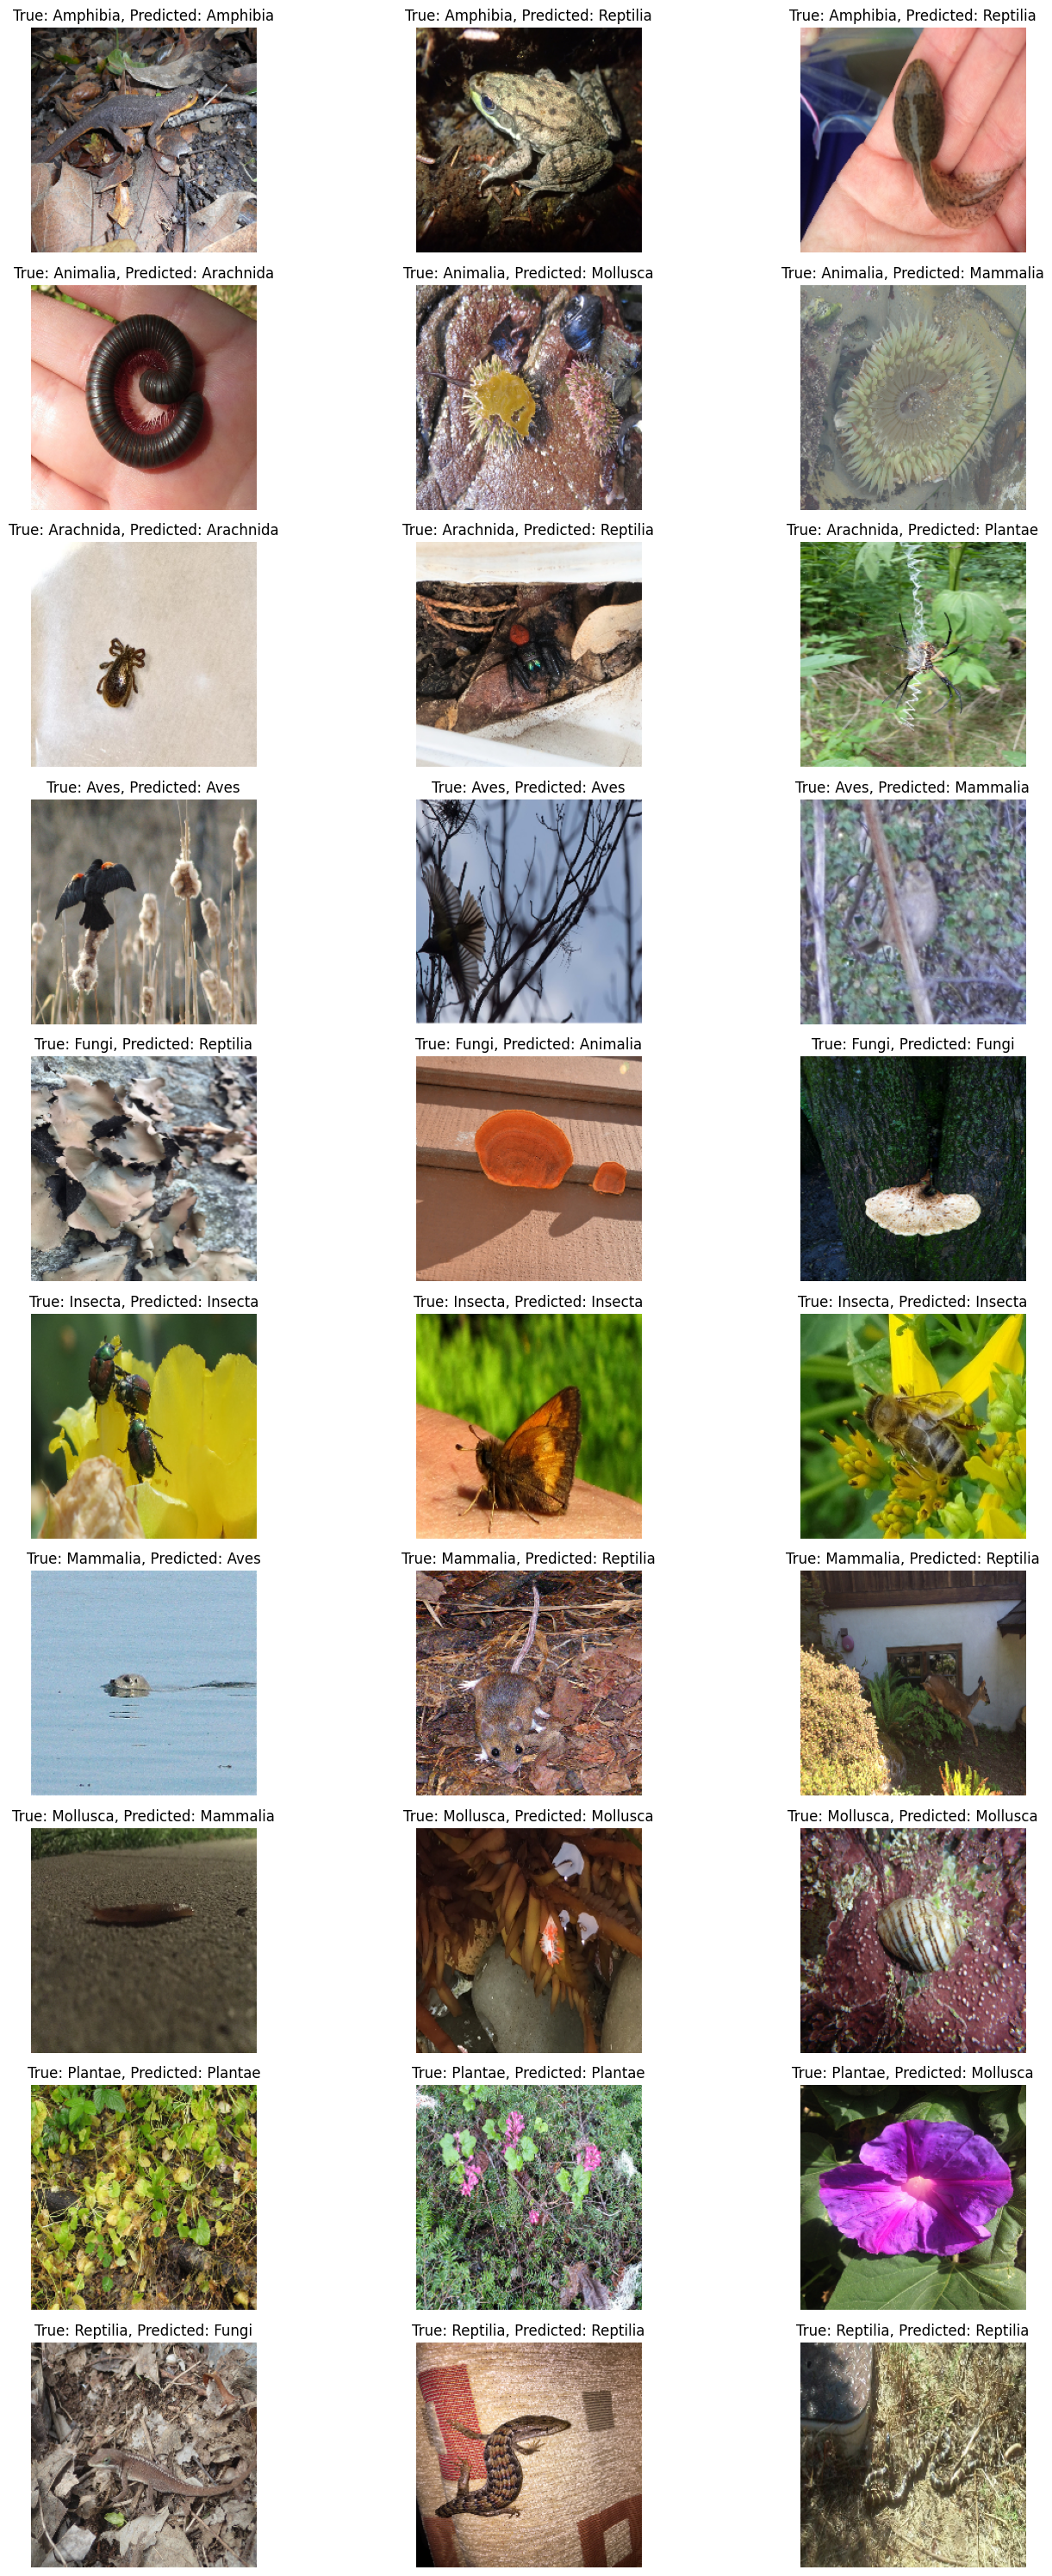

In [127]:
fig.savefig('image1.png', bbox_inches='tight')
# Convert the saved image to PIL Image
image = Image.open('image1.png')

In [116]:
# Convert the figure to an image
from PIL import Image

fig.canvas.draw()
image = Image.frombytes('RGB', fig.canvas.get_width_height(), fig.canvas.tostring_rgb())


In [125]:
sweep_config = {
    'method': 'grid',
    'name' : 'test-images12',
    'parameters': {
        'epochs': {
            'values': [1]
        }
  }
}

sweep_id = wandb.sweep(sweep = sweep_config, entity="abhinavtk", project='MA23M002-A2')

Create sweep with ID: a68r2e37
Sweep URL: https://wandb.ai/abhinavtk/MA23M002-A2/sweeps/a68r2e37


In [ ]:
def main():
    with wandb.init() as run:
        #run_name = "-f_num_"+str(wandb.config.filters_num)+"-f_num_"+wandb.config.filter_org+"-ac_fn_"+wandb.config.act_fn+\
                    #"-b_norm_"+str(wandb.config.batch_norm) + "-bs_"+str(wandb.config.batch_size) +"-neu_num"+str(wandb.config.num_neurons_dense)

        wandb.run.name = "test-image-output"
        #wandb.log({"image_pred": [wandb.Image(image, caption="Test Images and Predictions")]})
        wandb.log({"image_grid": [wandb.Image(image, caption="Test Images and Predictions", width=fig.get_figwidth(), height=fig.get_figheight())]})
wandb.agent(sweep_id, function = main, count = 1)
wandb.finish()